# Monte Carlo: Lecture 4 Excercise
_Jose Javier Fernández González_

Minimizing potential energy: Annealing method applied to find the global minimum of a two-dimensional Thompson atomic model

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd

## The Dimensionless Potential Energy Function:

$$
E_{pot} = \sum_{i=1}^N r_i ^2 + \sum_{i<j}^N \frac{1}{|r_i - r_j|}
$$

In [8]:
def calculate_potential_energy(R:np.ndarray):
    # Calculate the first sum
    first_term = np.sum(R**2) 

    # Calculate the second sum
    N = R.shape[0]
    second_term = 0
    for j in range(N):
        rij = R[j+1:] - R[j] # r_i - r_j for all i<j
        denominator = np.sqrt(np.sum(rij**2, axis=1)) # calculate all distances
        
        # If a distance is 0, return infinite (avoid crash)
        if np.any(denominator==0.0):
            return np.inf
        
        term = np.sum(1.0 / denominator) # take the inverse and sum all values
        second_term += term
    
    total_energy = first_term + second_term
    return total_energy

# Another option would be to calculate diff. subtract old r2_i add new r2_i and the same for second term 
# Improves efficiency from N2 to N

## Metropolis Algorithm

In [9]:
def metropolis_algorithm(func, old_x, new_x, T):
    # Calculate weight 
    f_old = func(old_x)
    f_new = func(new_x)
    
    w = np.exp(-(f_new - f_old) / T) if f_new != np.inf else 0

    # Generate random number and evaluate
    u = np.random.random() if w<1 else 0.

    # Accept or reject move
    if u==0. or int(w+u):
        # print(f"Accept: w:{w}, u:{u}, w+u:{w+u}")
        return new_x, f_new, 1
    else:
        # print(f"Reject: w:{w}, u:{u}, w+u:{w+u}")
        return old_x, f_old, 0

## Simulation

In [10]:
# Helper Functions
def gen_intial_config(N):
    return np.random.random((N,2))

def move_points(R, a=1,  mode="global"):
    if mode=="global":
        # generate displacement with amplitude a for all points 
        displacement =  2*np.random.random(R.shape) - 1 
        new_R = R + displacement * a
        return new_R
    elif mode=="local":
        # generate displacement with amplitude a for one point
        local_displacement =  2*np.random.random(2) - 1 
        # select random particle to move
        particle_num = np.random.randint(0,R.shape[0])
        new_R = np.concat([R[:particle_num], [R[particle_num] + local_displacement * a], R[particle_num+1:]])
        return new_R
    else:
        raise ValueError("`mode` should be either 'global' or 'local'")
# Local mode not correct, should calculate energy difference instead.

def get_shell_config(R, tol=0.5):
     # Compute radii
    radii = np.sqrt(np.sum(R**2, axis=1))
    radii.sort()

    shells = []
    current_shell = [radii[0]]

    for r in radii[1:]:
        if abs(r - np.mean(current_shell)) < tol:
            current_shell.append(r)
        else:
            shells.append(len(current_shell))
            current_shell = [r]

    shells.append(len(current_shell))

    return ",".join(str(n) for n in shells)

    
# SIMULATION
def run_sim(N, num_steps, T, dt, mode, visualization="", verbose=False):
    R = gen_intial_config(N)

    # LIVE VISUALIZATION
    if visualization=="live":
        plt.ion()
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title("Snapshots of particle positions")
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        scat = ax.scatter(R[:, 0], R[:, 1], s=60)
        fig.canvas.draw()
        fig.canvas.flush_events()

    # Main Loop
    total_accepted = 0
    energy_vals = []
    for i in range(num_steps):
        # Move Points
        new_R = move_points(R, a=dt, mode=mode)

        # Let the Metropolis Algorithm define the new R by accepting it or rejecting it
        R, energy, accepted = metropolis_algorithm(calculate_potential_energy, R, new_R, T)
        energy_vals.append(energy)
        total_accepted += accepted

        # Update Graph
        if visualization=="live":
            clear_output(wait=True)
            scat.set_offsets(R)
            display(fig)

    # Obtain results
    final_energy = energy_vals[-1]
    E_N = final_energy/N
    shell = get_shell_config(R)

    # Print Data
    if verbose:
        print(f"Final Energy: {final_energy:5e}")
        print(f"E/N: {E_N:5f}")
        print(f"Theoretical Value: {(N**(2/3) - 1)*2**(1/3) :5f}")
        print(f"Acceptance Rate: {total_accepted/num_steps}")

    # Final Visualization
    if visualization=="live":
        plt.ioff()
        plt.close(fig)
    elif visualization=="end":
        fig, (ax_pos, ax_E) = plt.subplots(1, 2, figsize=(11, 5))

        # Particle positions
        ax_pos.set_title(f"Snapshot of the position of {N} particles")
        ax_pos.set_xlabel("x")
        ax_pos.set_ylabel("y")
        ax_pos.set_aspect("equal", adjustable="box")
        ax_pos.scatter(R[:, 0], R[:, 1], s=60)

        # Potential energy 
        ax_E.set_title("Potential Energy Values")
        ax_E.set_xlabel("Iteration")
        ax_E.set_ylabel(r"$E_{\mathrm{pot}}$")
        ax_E.plot(range(num_steps), energy_vals)

        plt.tight_layout()
        plt.show()
    
    return final_energy, E_N, shell

## Simulation Results

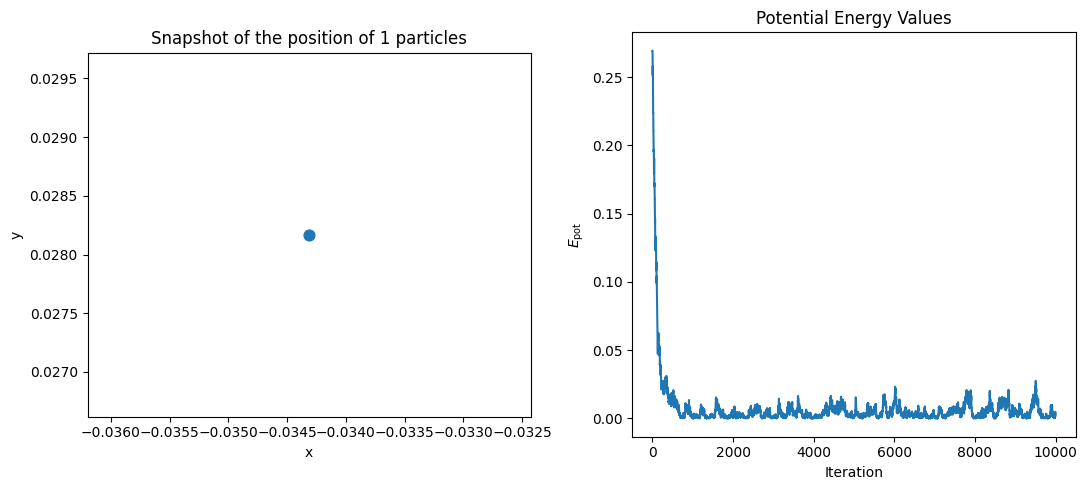

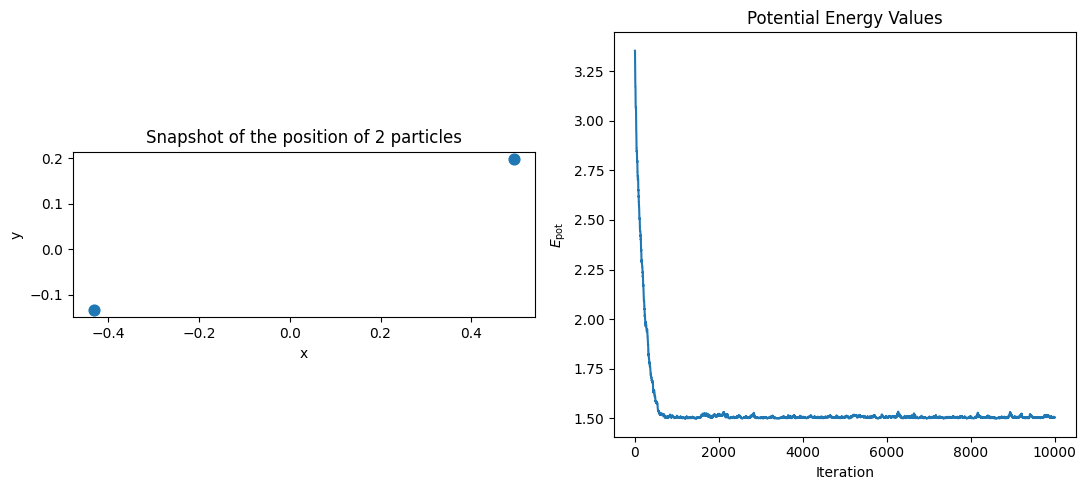

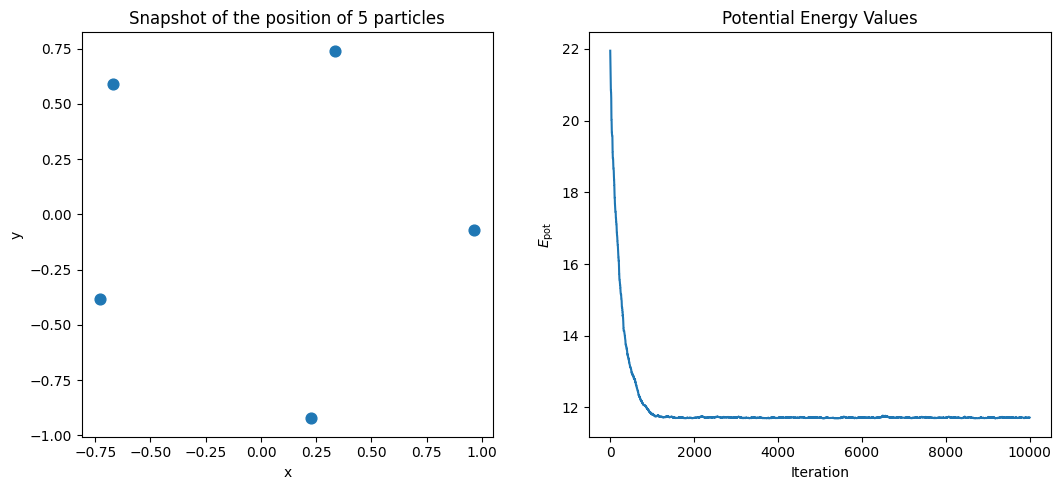

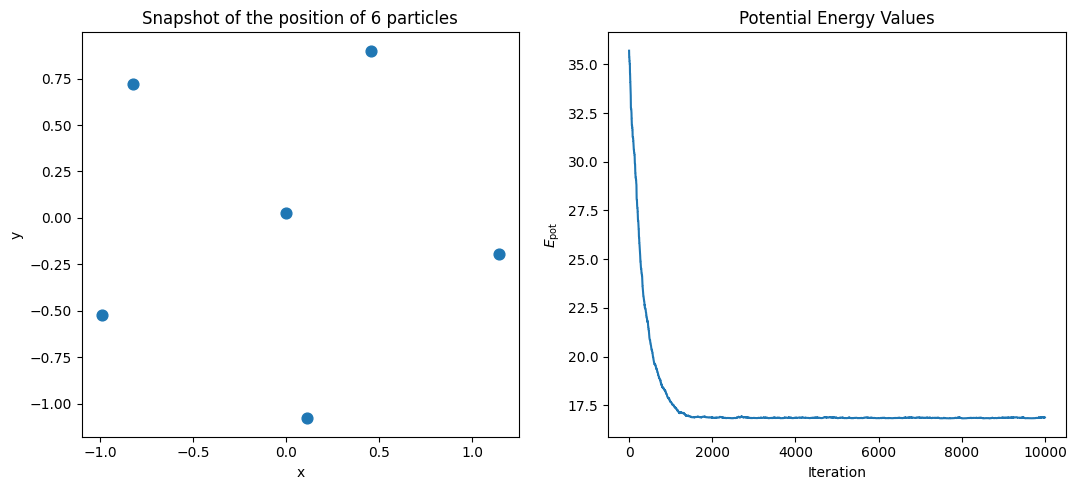

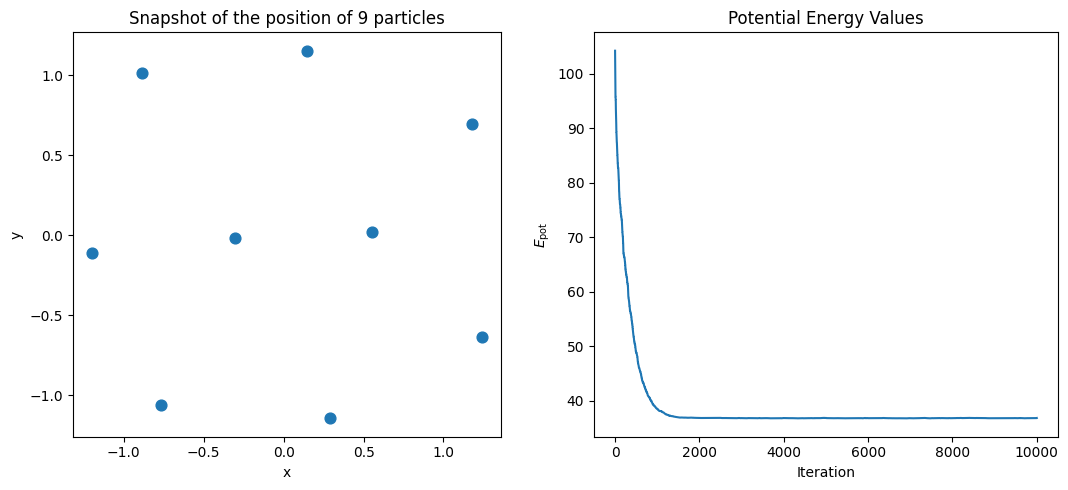

/tmp/ipykernel_106356/3365001054.py:6: RuntimeWarning: overflow encountered in exp
  w = np.exp(-(f_new - f_old) / T) if f_new != np.inf else 0


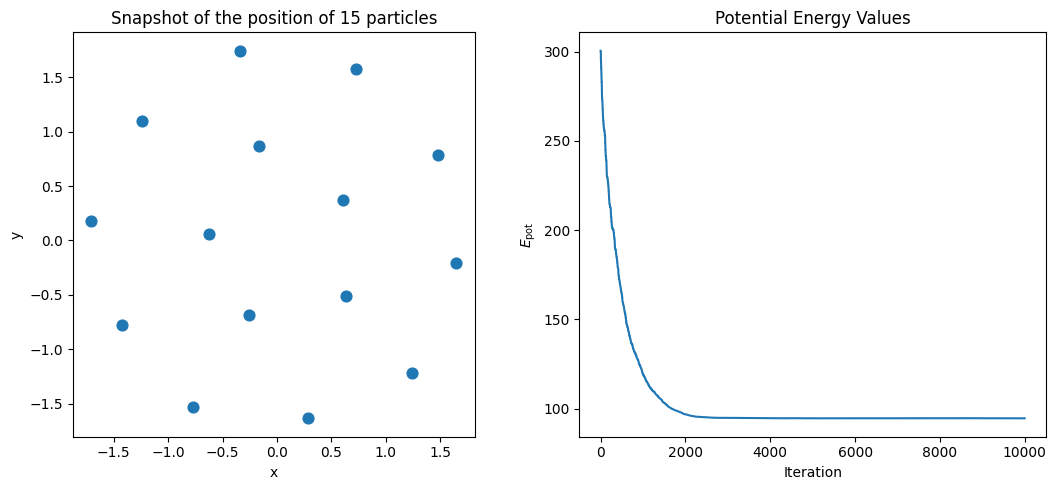

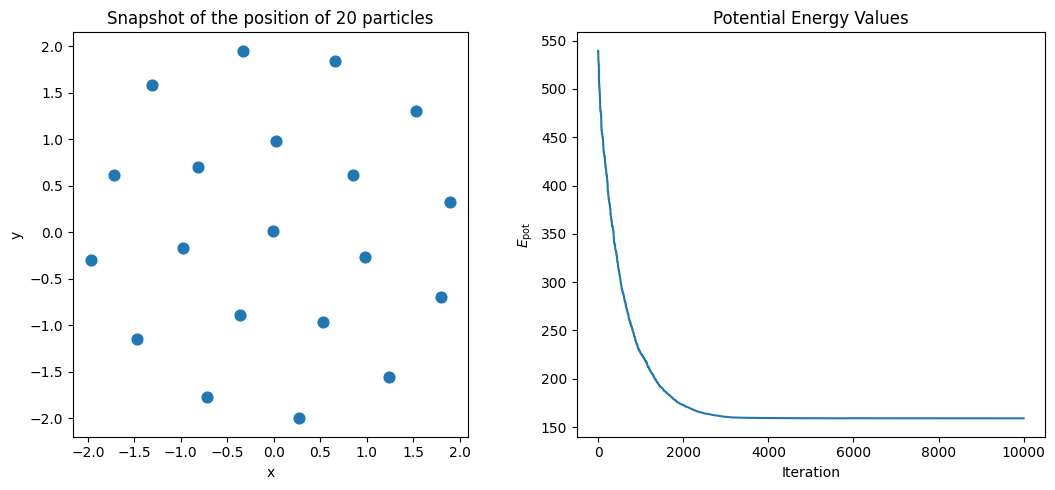

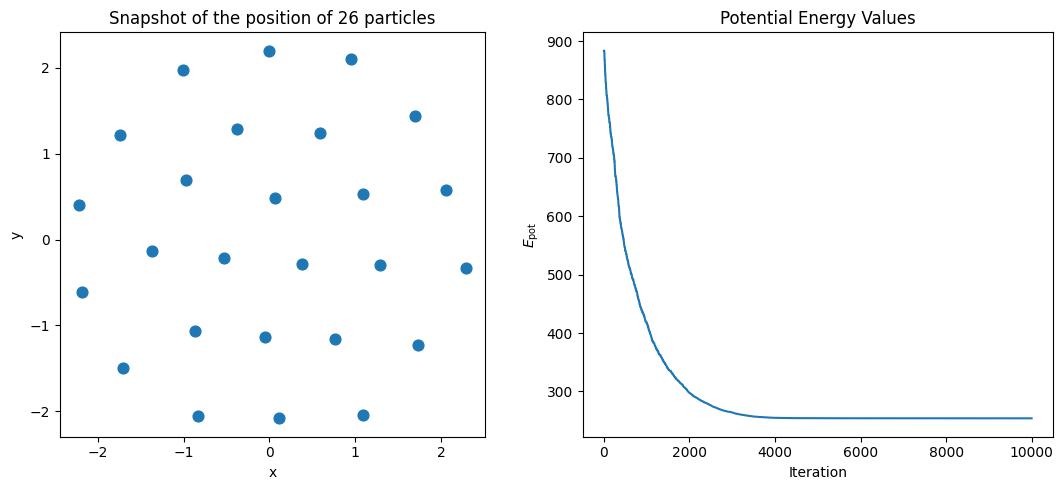

In [11]:
# SIMULATION PARAMS
num_steps = int(1e4)
T = 0.005
dt = 0.01
mode = "global"
N_vals = [1,2,5,6,9,15,20,26]
results_dict = {
    "N":[],
    "Config":[],
    "E_N":[]
}

for N in N_vals:
    _, E_N, config = run_sim(N, num_steps, T, dt, mode, "end", False)
    results_dict["N"].append(N)
    results_dict["E_N"].append(E_N)
    results_dict["Config"].append(config)

### Comparing with PRB Results

In [16]:
Sim_Data = pd.DataFrame(results_dict).set_index("N")
PRB_Data = pd.read_csv("prb_results.csv").set_index("N").drop("P", axis=1)
Comparison_Data = Sim_Data.join(PRB_Data, how="left", lsuffix=" Simulated", rsuffix=" PRB")
Comparison_Data = Comparison_Data[sorted(Comparison_Data.columns)]
Comparison_Data["Relative Error (%)"] = 100 * abs(Comparison_Data["E_N PRB"] - Comparison_Data["E_N Simulated"]) / Comparison_Data["E_N PRB"]
Comparison_Data

,Config PRB,Config Simulated,E_N PRB,E_N Simulated,Relative Error (%)
N,,,,,
1,1,1,0.00000,0.001971,inf
2,2,2,0.75000,0.752234,0.297905
5,5,5,2.33845,2.343675,0.223433
6,"1, 5","1,5",2.80456,2.812931,0.298483
9,"2, 7","2,7",4.08813,4.095511,0.180548
15,"5, 10","5,10",6.30758,6.310820,0.051366
20,"1, 7, 12","1,7,12",7.94961,7.953899,0.053958
26,NaN,"3,9,14",NaN,9.766769,NaN
